In [1]:
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from prefect.blocks.system import Secret
from sqlalchemy import create_engine, select
from sqlalchemy.orm import Session, aliased
from mcpdb.tables import Asset, Provider, ProviderAssetOrder

In [2]:
postgresql_password: str = (await Secret.load("postgresql-password")).get()
host = "db-postgresql-lon1-65351-do-user-18535103-0.m.db.ondigitalocean.com"
port = 25060
database = "defaultdb"
user = "doadmin"
url = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user=user,
    password=postgresql_password,
    host=host,
    port=port,
    database=database,
)

In [3]:
asset_pair: dict[int, str] = {}
with Session(create_engine(url)) as session:
    stmt = select(Asset).where(Asset.is_active)
    assets = session.scalars(stmt).all()
    asset_pair: dict[int, str] = {asset.id: asset.name for asset in assets}
    print("Available assets:")
    for asset_id, asset_name in asset_pair.items():
        print(f"{asset_id}: {asset_name}")
asset_1 = 1
asset_2 = 2
start_datetime = datetime.now() - timedelta(days=1)
end_datetime = datetime.now()
print(
    f"Comparing {asset_pair[asset_1]} and {asset_pair[asset_2]} from {start_datetime} onwards"
)

Available assets:
1: BTC
2: USD
3: ETH
Comparing BTC and USD from 2025-06-22 20:07:00.071818 onwards


In [4]:
engine = create_engine(url, connect_args={"sslmode": "require"})

In [5]:
# Create aliases for Asset to use in multiple joins
FromAsset = aliased(Asset)
ToAsset = aliased(Asset)

# Create the query
with Session(engine) as session:
    stmt = (
        select(
            ProviderAssetOrder.id,
            ProviderAssetOrder.timestamp,
            ProviderAssetOrder.price,
            ProviderAssetOrder.volume,
            FromAsset.name.label("from_asset_name"),
            ToAsset.name.label("to_asset_name"),
            Provider.name.label("provider_name"),
        )
        .join(FromAsset, ProviderAssetOrder.from_asset_id == FromAsset.id)
        .join(ToAsset, ProviderAssetOrder.to_asset_id == ToAsset.id)
        .join(Provider, ProviderAssetOrder.provider_id == Provider.id)
    )

    stmt = stmt.where(
        ((FromAsset.id == asset_1) & (ToAsset.id == asset_2))
        | ((FromAsset.id == asset_2) & (ToAsset.id == asset_1)),
        ProviderAssetOrder.timestamp >= start_datetime,
        ProviderAssetOrder.timestamp <= end_datetime,
    ).order_by(ProviderAssetOrder.timestamp)

    result_df = pd.read_sql(stmt, session.bind)

result_df

,id,timestamp,price,volume,from_asset_name,to_asset_name,provider_name
0,7280969,2025-06-22 20:07:01,98886.0,0.292,BTC,USD,Kraken
1,7280971,2025-06-22 20:07:01,98891.0,5.057,BTC,USD,Kraken
2,7280974,2025-06-22 20:07:01,98947.5,0.310,BTC,USD,Kraken
3,7280968,2025-06-22 20:07:01,98875.9,0.011,BTC,USD,Kraken
4,7280992,2025-06-22 20:07:01,98851.2,0.103,USD,BTC,Kraken
...,...,...,...,...,...,...,...
769294,9206007,2025-06-23 20:07:00,103089.5,1.869,USD,BTC,Kraken
769295,9205419,2025-06-23 20:07:00,103194.3,0.252,BTC,USD,Kraken
769296,9206006,2025-06-23 20:07:00,102889.0,4.860,USD,BTC,Kraken
769297,9206005,2025-06-23 20:07:00,102881.4,4.860,USD,BTC,Kraken


/var/folders/tc/qpkxsjrx4s72nqyhf67_1ctw0000gn/T/ipykernel_37032/2230401202.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


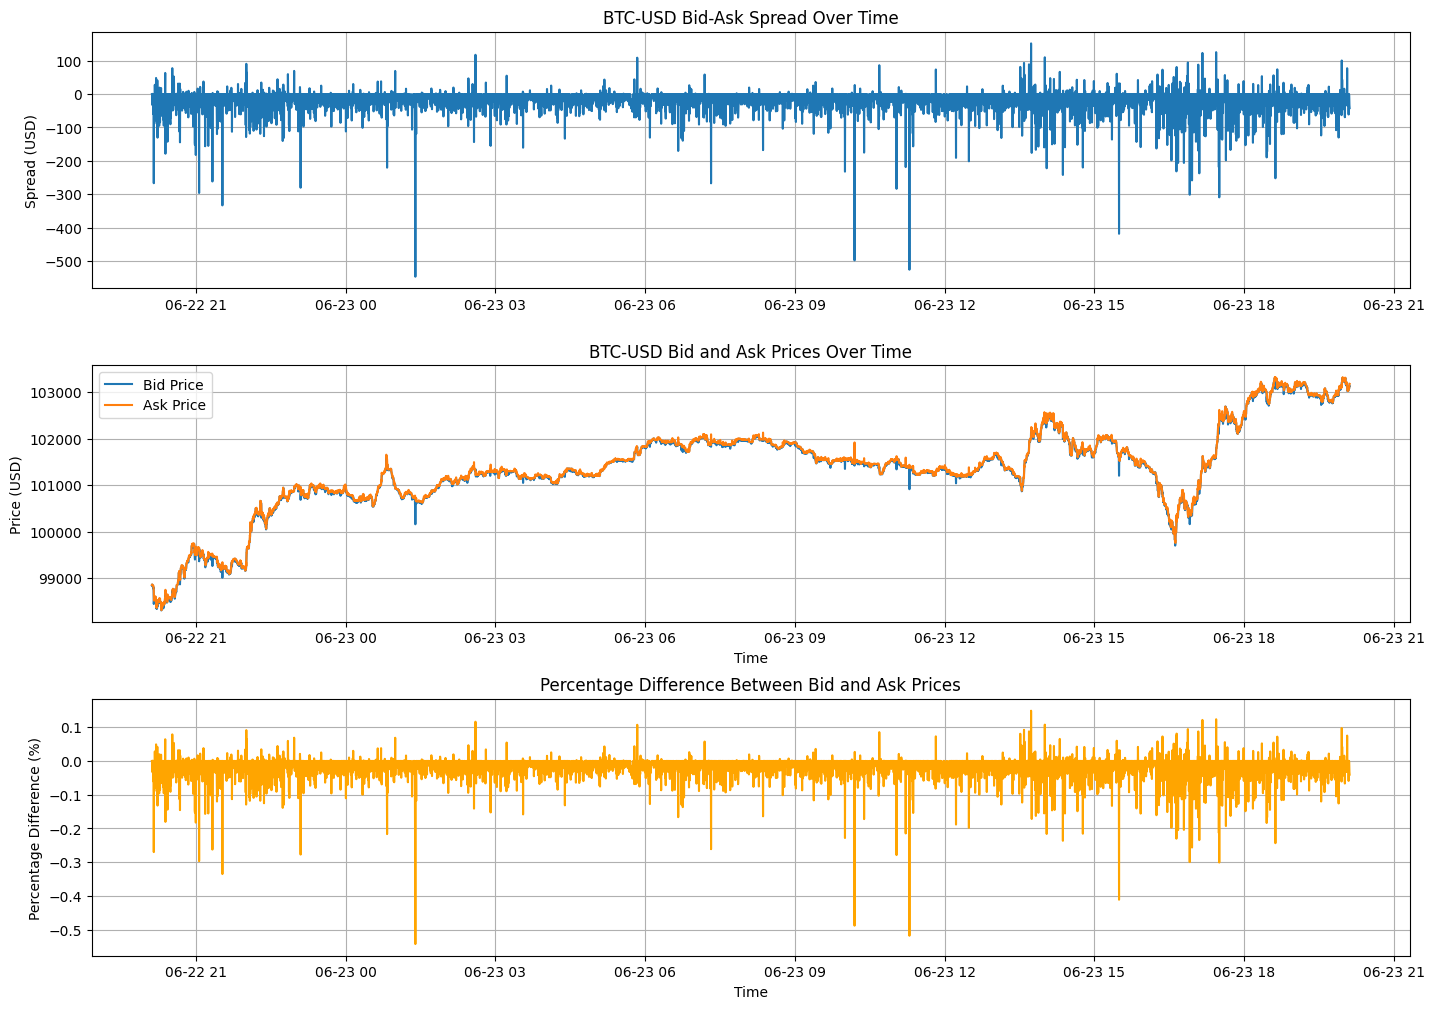

In [6]:
# Filter for asset pairs only
asset_1_name = asset_pair[asset_1]
asset_2_name = asset_pair[asset_2]

filtered_df = result_df[
    (
        (result_df["from_asset_name"] == asset_1_name)
        & (result_df["to_asset_name"] == asset_2_name)
    )
    | (
        (result_df["from_asset_name"] == asset_2_name)
        & (result_df["to_asset_name"] == asset_1_name)
    )
]

# Identify bid and ask orders
ask_df = filtered_df[
    filtered_df["from_asset_name"] == asset_1_name
]  # Selling asset_1 for asset_2 (ask)
bid_df = filtered_df[
    filtered_df["from_asset_name"] == asset_2_name
]  # Buying asset_1 with asset_2 (bid)

# Resample data to get time-based aggregation (per minute)
period = "15s"  # 15 seconds
bid_prices = bid_df.set_index("timestamp").resample(period)["price"].max()
ask_prices = ask_df.set_index("timestamp").resample(period)["price"].min()

# Calculate the spread
spread_df = pd.DataFrame({"bid": bid_prices, "ask": ask_prices})
spread_df["spread"] = spread_df["bid"] - spread_df["ask"]
spread_df = spread_df.dropna()

# Create a figure with two subplots
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.3)
fig = plt.figure(figsize=(17, 12))
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# Plot spread
ax1.plot(spread_df.index, spread_df["spread"])
ax1.set_title(f"{asset_1_name}-{asset_2_name} Bid-Ask Spread Over Time")
ax1.set_ylabel(f"Spread ({asset_2_name})")
ax1.grid(True)

# Plot bid and ask prices
ax2.plot(spread_df.index, spread_df["bid"], label="Bid Price")
ax2.plot(spread_df.index, spread_df["ask"], label="Ask Price")
ax2.set_title(f"{asset_1_name}-{asset_2_name} Bid and Ask Prices Over Time")
ax2.set_xlabel("Time")
ax2.set_ylabel(f"Price ({asset_2_name})")
ax2.legend()
ax2.grid(True)

# Plot percentage difference in ask price relative to bid price
spread_df["percentage_difference"] = (
    (spread_df["bid"] - spread_df["ask"]) / spread_df["ask"] * 100
)
ax3.plot(spread_df.index, spread_df["percentage_difference"], color="orange")
ax3.set_title("Percentage Difference Between Bid and Ask Prices")
ax3.set_xlabel("Time")
ax3.set_ylabel("Percentage Difference (%)")
ax3.grid(True)

plt.tight_layout()
plt.show()